# Fit binned poly-tccd acquisition probability model in 2018-11

This is a DEVELOPMENT model.

This is an intermediate model which collects the probabilities within narrow magnitude
bins and fits a quadratic polynomial model to the data as a function of CCD temperature.

The fit and plot of polynomial coefficients in each mag bin are used as starting values
in the `fit_acq_model-2018-11-poly-spline-tccd` notebook.

In [1]:
import sys
import os
from itertools import count
from pathlib import Path
sys.path.insert(0, str(Path(os.environ['HOME'], 'git', 'skanb', 'pea-test-set')))
import utils as asvt_utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.time import Time
import tables
from scipy import stats
from scipy.interpolate import CubicSpline
from Chandra.Time import DateTime
from astropy.table import Table
from chandra_aca.star_probs import get_box_delta

%matplotlib inline

In [2]:
SKA = Path(os.environ['SKA'])

## Get acq stats data and clean

In [3]:
# Make a map of AGASC_ID to AGACS 1.7 MAG_ACA.  The acq_stats.h5 file has whatever MAG_ACA
# was in place at the time of planning the loads.
with tables.open_file(str(SKA / 'data' / 'agasc' / 'miniagasc_1p7.h5'), 'r') as h5:
    agasc_mag_aca = h5.root.data.col('MAG_ACA')
    agasc_id = h5.root.data.col('AGASC_ID')
    has_color3 = h5.root.data.col('RSV3') != 0  # 
    red_star = np.isclose(h5.root.data.col('COLOR1'), 1.5)
    mag_aca_err = h5.root.data.col('MAG_ACA_ERR') / 100
    red_mag_err = red_star & ~has_color3  # MAG_ACA, MAG_ACA_ERR is potentially inaccurate

In [4]:
agasc1p7_idx = {id: idx for id, idx in zip(agasc_id, count())}
agasc1p7 = Table([agasc_mag_aca, mag_aca_err, red_mag_err], 
                 names=['mag_aca', 'mag_aca_err', 'red_mag_err'], copy=False)

In [5]:
acq_file = str(SKA / 'data' / 'acq_stats' / 'acq_stats.h5')
with tables.open_file(str(acq_file), 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'halfwidth': 'halfw',
             'warm_pix': 'n100_warm_frac',
             'mag_aca': 'mag_aca',
             'mag_obs': 'mean_trak_mag',
             'known_bad': 'known_bad',
             'color': 'color1',
            'img_func': 'img_func', 
            'ion_rad': 'ion_rad',
            'sat_pix': 'sat_pix',
             'agasc_id': 'agasc_id',
             't_ccd': 'ccd_temp',
            'slot': 'slot'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))    

In [6]:
year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')

In [7]:
# Create 'fail' column, rewriting history as if the OBC always
# ignore the MS flag in ID'ing acq stars.
#
# UPDATE: is ion_rad being ignored on-board?  (Not as of 2018-11)
#
obc_id = acqs['obc_id']
obc_id_no_ms = (acqs['img_func'] == 'star') & ~acqs['sat_pix'] & ~acqs['ion_rad']
acqs['fail'] = np.where(obc_id | obc_id_no_ms, 0.0, 1.0)
acqs['mag_aca'] = [agasc1p7['mag_aca'][agasc1p7_idx[agasc_id]] for agasc_id in acqs['agasc_id']]
acqs['red_mag_err'] = [agasc1p7['red_mag_err'][agasc1p7_idx[agasc_id]] for agasc_id in acqs['agasc_id']]
acqs['mag_aca_err'] = [agasc1p7['mag_aca_err'][agasc1p7_idx[agasc_id]] for agasc_id in acqs['agasc_id']]
acqs['asvt'] = False

In [8]:
# Filter for year and mag (previously used data through 2007:001)
#
# UPDATE this to be between 4 to 5 years from time of recalibration.
#
year_min = 2014.5
year_max = DateTime('2018-10-30').frac_year
ok = ((acqs['year'] > year_min) & (acqs['year'] < year_max) & 
      (acqs['mag_aca'] > 7.0) & (acqs['mag_aca'] < 11) &
      (~np.isclose(acqs['color'], 0.7)))

In [9]:
# Filter known bad obsids
print('Filtering known bad obsids, start len = {}'.format(np.count_nonzero(ok)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (acqs['obsid'] != badid)
print('Filtering known bad obsids, end len = {}'.format(np.count_nonzero(ok)))

Filtering known bad obsids, start len = 56547
Filtering known bad obsids, end len = 56547


## Get ASVT data and make it look more like acq stats data

In [10]:
peas = Table.read('pea_analysis_results_2018_299_CCD_temp_performance.csv', format='ascii.csv')
peas = asvt_utils.flatten_pea_test_data(peas)

In [11]:
# Fuzz mag and T_ccd by a bit for plotting and fitting.
fpeas = Table([peas['star_mag'], peas['ccd_temp'], peas['search_box_hw']],
              names=['mag_aca', 't_ccd', 'halfwidth'])
fpeas['year'] = np.random.uniform(2019.0, 2019.5, size=len(peas))
fpeas['color'] = 1.0
fpeas['quarter'] = (np.trunc((fpeas['year'] - year_q0) * 4)).astype('f4')
fpeas['fail'] = 1.0 - peas['search_success']
fpeas['asvt'] = True
fpeas['red_mag_err'] = False
fpeas['mag_obs'] = 0.0

## Combine flight acqs and ASVT data

In [12]:
data_all = vstack([acqs[ok]['year', 'fail', 'mag_aca', 't_ccd', 'halfwidth', 'quarter', 
                            'color', 'asvt', 'red_mag_err', 'mag_obs'], 
                   fpeas])
data_all.sort('year')

## Compute box probit delta term based on box size

In [13]:
# Adjust probability (in probit space) for box size. 
data_all['box_delta'] = get_box_delta(data_all['halfwidth'])

In [14]:
data_all = data_all.group_by('quarter')
data_all0 = data_all.copy()  # For later augmentation with simulated red_mag_err stars
data_mean = data_all.groups.aggregate(np.mean)

## Model definition

In [15]:
def t_ccd_normed(t_ccd):
    return (t_ccd + 8.0) / 8.0

def p_fail(pars, 
           t_ccd, tc2=None,
           box_delta=0, rescale=True):
    """
    Acquisition probability model

    :param pars: 7 parameters (3 x offset, 3 x scale, p_fail for bright stars)
    :param tc, tc2: t_ccd, t_ccd ** 2
    :param box_delta: search box half width (arcsec)
    """
    p0, p1, p2 = pars

    tc = t_ccd_normed(t_ccd) if rescale else t_ccd
    
    if tc2 is None:
        tc2 = tc ** 2
    
    # Make sure box_delta has right dimensions
    tc, box_delta = np.broadcast_arrays(tc, box_delta)

    probit_p_fail = p0 + p1 * tc + p2 * tc2 + box_delta
    p_fail = stats.norm.cdf(probit_p_fail.clip(-8, 8))  # transform from probit to linear probability

    return p_fail

def p_acq_fail(data=None):
    """
    Sherpa fit function wrapper to ensure proper use of data in fitting.
    """
    if data is None:
        data = data_all
        
    tc = t_ccd_normed(data['t_ccd'])
    tc2 = tc ** 2
    box_delta = data['box_delta']
    
    def sherpa_func(pars, x=None):
        return p_fail(pars, tc, tc2, box_delta, rescale=False)

    return sherpa_func

In [16]:
def calc_binom_stat(data, model, staterror=None, syserror=None, weight=None, bkg=None):
    """
    Calculate log-likelihood for a binomial probability distribution
    for a single trial at each point.
    
    Defining p = model, then probability of seeing data == 1 is p and
    probability of seeing data == 0 is (1 - p).  Note here that ``data``
    is strictly either 0.0 or 1.0, and np.where interprets those float
    values as False or True respectively.
    """
    fit_stat = -np.sum(np.log(np.where(data, model, 1.0 - model)))    
    return fit_stat, np.ones(1)

In [17]:
def fit_poly_model(data_mask=None):
    from sherpa import ui

    data = data_all if data_mask is None else data_all[data_mask]
    
    comp_names = ['p0', 'p1', 'p2']

    data_id = 1
    ui.set_method('simplex')
    ones = np.ones(len(data))
    ui.load_user_stat('binom_stat', calc_binom_stat, lambda x: ones)
    ui.set_stat(binom_stat)
    # ui.set_stat('cash')
    ui.load_user_model(p_acq_fail(data), 'model')
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from fit of all data
    fmod = ui.get_model_component('model')
    for comp_name in comp_names:
        setattr(fmod, comp_name, 0.0)
        comp = getattr(fmod, comp_name)
        comp.max = 10
        comp.min = -10

    ui.fit(data_id)
    return ui.get_fit_results()

## Plotting and validation

In [18]:
def plot_fails_mag_aca_vs_t_ccd(mag_bins, data_all=data_all, year0=2014.0):
    ok = (data_all['year'] > year0) & ~data_all['fail'].astype(bool)
    da = data_all[ok]
    fuzzx = np.random.uniform(-0.3, 0.3, len(da))
    fuzzy = np.random.uniform(-0.125, 0.125, len(da))
    plt.plot(da['t_ccd'] + fuzzx, da['mag_aca'] + fuzzy, '.C0', markersize=4)

    ok = (data_all['year'] > year0) & data_all['fail'].astype(bool)
    da = data_all[ok]
    fuzzx = np.random.uniform(-0.3, 0.3, len(da))
    fuzzy = np.random.uniform(-0.125, 0.125, len(da))
    plt.plot(da['t_ccd'] + fuzzx, da['mag_aca'] + fuzzy, '.C1', markersize=4, alpha=0.8)
    
    # plt.xlim(-18, -10)
    # plt.ylim(7.0, 11.1)
    x0, x1 = plt.xlim()
    for y in mag_bins:
        plt.plot([x0, x1], [y, y], '-', color='r', linewidth=2, alpha=0.8)
    plt.xlabel('T_ccd (C)')
    plt.ylabel('Mag_aca')
    plt.title(f'Acq successes (blue) and failures (orange) since {year0}')
    plt.grid()

In [19]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None, probit=False):
    data = data_all if mask is None else data_all[mask]
    data['model'] = p_acq_fail(data)(pars)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    data_fail = data_mean['fail']
    model_fail = np.array(data_mean['model'])
    
    fail_sigmas = np.sqrt(data_fail * len_groups) / len_groups
    
    # Possibly plot the data and model probabilities in probit space
    if probit:
        dp = stats.norm.ppf(np.clip(data_fail + fail_sigmas, 1e-6, 1-1e-6))
        dm = stats.norm.ppf(np.clip(data_fail - fail_sigmas, 1e-6, 1-1e-6))
        data_fail = stats.norm.ppf(data_fail)
        model_fail = stats.norm.ppf(model_fail)
        fail_sigmas = np.vstack([data_fail - dm, dp - data_fail])
            
    plt.errorbar(data_mean[group_col], data_fail, yerr=fail_sigmas, 
                 fmt='.' + colors[1:], label=label, markersize=8)
    plt.plot(data_mean[group_col], model_fail, '-' + colors[0])
    
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [20]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag_aca'] > mag0) & (data_all['mag_aca'] < mag1)
    return ok

In [21]:
def t_ccd_filter(t_ccd0, t_ccd1):
    ok = (data_all['t_ccd'] > t_ccd0) & (data_all['t_ccd'] < t_ccd1)
    return ok

In [22]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

### Define magnitude bins for fitting and show data

In [23]:
mag_centers = np.array([6.3, 8.1, 9.1, 9.55, 9.75, 10.0, 10.25, 10.55, 10.75, 11.0])
mag_bins = (mag_centers[1:] + mag_centers[:-1]) / 2
mag_means = np.array([8.0, 9.0, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75])

In [24]:
for m0, m1, mm in zip(mag_bins[:-1], mag_bins[1:], mag_means):
    ok = (data_all['asvt'] == False) & (data_all['mag_aca'] >= m0) & (data_all['mag_aca'] < m1)
    print(f"m0={m0:.2f} m1={m1:.2f} mean_mag={data_all['mag_aca'][ok].mean():.2f} vs. {mm}")

m0=7.20 m1=8.60 mean_mag=8.05 vs. 8.0
m0=8.60 m1=9.32 mean_mag=8.99 vs. 9.0
m0=9.32 m1=9.65 mean_mag=9.48 vs. 9.5
m0=9.65 m1=9.88 mean_mag=9.76 vs. 9.75
m0=9.88 m1=10.12 mean_mag=9.99 vs. 10.0
m0=10.12 m1=10.40 mean_mag=10.23 vs. 10.25
m0=10.40 m1=10.65 mean_mag=10.50 vs. 10.5
m0=10.65 m1=10.88 mean_mag=10.75 vs. 10.75


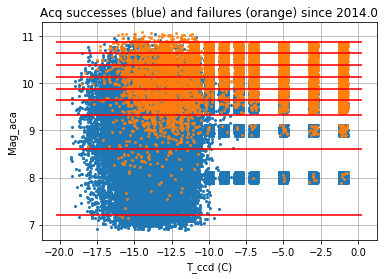

In [25]:
plot_fails_mag_aca_vs_t_ccd(mag_bins)

### Color != 1.5 fit (this is MOST acq stars)

In [26]:
# fit = fit_sota_model(data_all['color'] == 1.5, ms_disabled=True)
mask_no_1p5 = ((data_all['red_mag_err'] == False) & 
               (data_all['t_ccd'] > -16) &
               (data_all['t_ccd'] < -0.5))

In [27]:
mag0s, mag1s = mag_bins[:-1], mag_bins[1:]
fits = {}
for m0, m1 in zip(mag0s, mag1s):
    print(m0, m1)
    fits[m0, m1] = fit_poly_model(mask_no_1p5 & mag_filter(m0, m1))

7.2 8.6
failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'
Dataset               = 1
Method                = neldermead
Statistic             = binom_stat
Initial fit statistic = 11071.4
Final fit statistic   = 438.423 at function evaluation 371
Data points           = 14245
Degrees of freedom    = 14242
Change in statistic   = 10633
   model.p0       -2.90342    
   model.p1       0.515897    
   model.p2       0.936276    
8.6 9.325
Dataset               = 1
Method                = neldermead
Statistic             = binom_stat
Initial fit statistic = 12442.1
Final fit statistic   = 1266.71 at function evaluation 395
Data points           = 16521
Degrees of freedom    = 16518
Change in statistic   = 11175.4
   model.p0       -1.97685    
   model.p1       0.799449    
   model.p2       0.252545    
9.325 9.65
Dataset               = 1
Method                = neldermead
Statistic             = binom_stat
Initial fit statisti

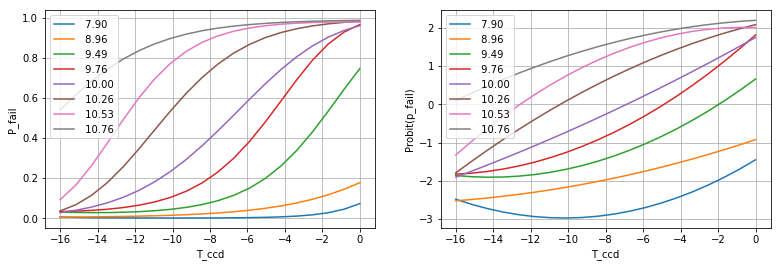

In [28]:
colors = [f'kC{i}' for i in range(9)]

# This computes probabilities for 120 arcsec boxes, corresponding to raw data
t_ccds = np.linspace(-16, -0, 20)
plt.figure(figsize=(13, 4))

for subplot in (1, 2):
    plt.subplot(1, 2, subplot)
    for m0_m1, color in zip(list(fits), colors):
        fit = fits[m0_m1]
        m0, m1 = m0_m1
        probs = p_fail(fit.parvals, t_ccds)
        if subplot == 2:
            probs = stats.norm.ppf(probs)
        plt.plot(t_ccds, probs, label=f'{(m0 + m1) / 2: .2f}')

    plt.legend()
    plt.xlabel('T_ccd')
    plt.ylabel('P_fail' if subplot == 1 else 'Probit(p_fail)')
    plt.grid()

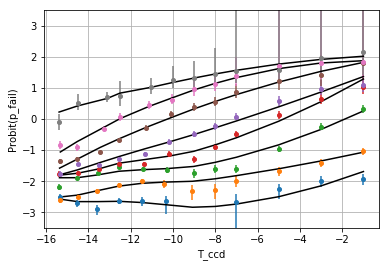

In [29]:
for m0_m1, color in zip(list(fits), colors):
    fit = fits[m0_m1]
    m0, m1 = m0_m1
    plot_fit_grouped(fit.parvals, 't_ccd', 1.0, 
                     mask=mask_no_1p5 & mag_filter(m0, m1), 
                     probit=True, colors=color, label=str(m0_m1))
plt.grid()
plt.ylim(-3.5, 3.5)
plt.ylabel('Probit(p_fail)')
plt.xlabel('T_ccd')
# plt.legend();

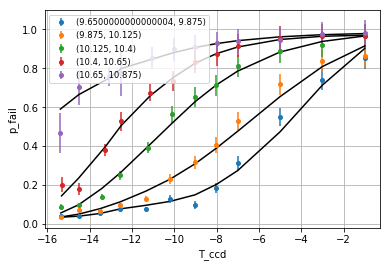

In [30]:
colors = [f'kC{i}' for i in range(9)]
for m0_m1, color in zip(list(fits)[3:], colors):
    fit = fits[m0_m1]
    m0, m1 = m0_m1
    plot_fit_grouped(fit.parvals, 't_ccd', 1.0, 
                     mask=mask_no_1p5 & mag_filter(m0, m1), 
                     probit=False, colors=color, label=str(m0_m1))
plt.grid()
plt.ylabel('p_fail')
plt.xlabel('T_ccd')
plt.legend(fontsize='small', loc='upper left');

In [31]:
def print_pvals(ps, idx):
    ps_str = ', '.join(f'{p:.3f}' for p in ps)
    print(f'spline_p[{idx}] = np.array([{ps_str}])')

spline_p[0] = np.array([-2.816, -1.937, -0.259, 1.188, 1.564])
spline_p[1] = np.array([0.543, 0.832, 1.827, 1.694, 1.049])
spline_p[2] = np.array([0.872, 0.293, 0.180, -0.865, -0.415])


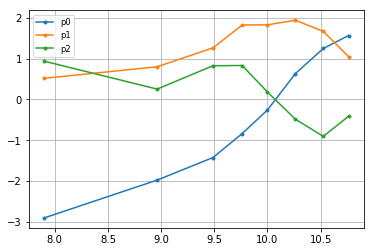

In [32]:
spline_mags = np.array([8.5, 9.25, 10.0, 10.4, 10.7])
spline_mags = np.array([8.0, 9.0, 10.0, 10.5, 11])
p0s = []
p1s = []
p2s = []
mags = []
for m0_m1, fit in fits.items():
    ps = fit.parvals
    m0, m1 = m0_m1
    mags.append((m0 + m1) / 2)
    p0s.append(ps[0])
    p1s.append(ps[1])
    p2s.append(ps[2])
plt.plot(mags, p0s, '.-', label='p0')
plt.plot(mags, p1s, '.-', label='p1')
plt.plot(mags, p2s, '.-', label='p2')
plt.legend(fontsize='small')
plt.grid()
print_pvals(np.interp(spline_mags, mags, p0s), 0)
print_pvals(np.interp(spline_mags, mags, p1s), 1)
print_pvals(np.interp(spline_mags, mags, p2s), 2)